# InSitu Merge of data using Pandas
### Super fast mechanism for merging data (faster than you can write).

# Includes and Libraries

In [1]:
############################################
#INCLUDES
############################################
import csv
from datetime import datetime, timedelta
import fnmatch
import statistics
import pickle

#number crunching
import numpy as np
import pandas as pd
import xarray as xr

#plotting
import matplotlib as matplt
import matplotlib.pyplot as plt
import seaborn as sns

#a set of libraries that perhaps should always be in Python source
import os 
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

#Import a custom library, in this case a fairly useful logging framework
debug_lib_location = Path("./")
sys.path.append(str(debug_lib_location))
import debug

root_location=Path("."+os.sep+"data");

In [2]:
############################################
#JUPYTER NOTEBOOK OUTPUT CONTROL / FORMATTING
############################################
#set floating point to 4 places to things don't run loose
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(precision=4)

# Variable declaration

In [3]:
############################################
#GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 1
SRC_DIR=root_location

DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "InSitu-Flow-Thru"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

#used for values outside standard ASCII, just do it, you'll need it
ENCODING  ="utf-8"
############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING

#define ACS data setup
ACS_FILE="ACS.txt"
ACS_HEADER=["%Year","Month","Day","Hour","Minute","Second(UTC)","Longitude(deg)","Latitude(deg)","Pressure(dbar)","C400","C404.1","C407.1","C410.5","C413.9","C417.4","C421.5","C426","C430.1","C433.8","C437.9","C442.1","C446.3","C451.1","C455.7","C459.9","C464.1","C468.5","C473.3","C478","C483.1","C487.6","C491.8","C496","C500.1","C504.8","C509.5","C514.4","C519.2","C523.9","C528.2","C532.3","C536.6","C540.9","C545.4","C549.9","C554.3","C558.7","C563.2","C567.6","C571.5","C575.4","C579.3","C582.9","C587.6","C591.7","C596","C600.6","C605","C609.3","C613.9","C618.4","C622.5","C626.5","C630.9","C635","C639.3","C643.6","C647.9","C652.7","C657","C661.4","C665.9","C670.3","C674.7","C678.8","C683.2","C687.1","C690.8","C694.7","C698.9","C702.3","C706.3","C710","C714.2","C717.6","C721.4","C725.6","C729.2","C732.7","C735.9","C739.4","C743.7","A398.4","A402.1","A405.7","A408.9","A412.3","A415.8","A419.8","A424","A428.3","A432.2","A436.1","A440.3","A444.8","A449.5","A454.1","A458.3","A462.4","A466.8","A471.5","A476.4","A481.3","A486","A490.2","A494.4","A498.8","A503.1","A507.8","A512.6","A517.7","A522.5","A526.8","A531.1","A535.3","A539.7","A544.2","A548.7","A553.1","A557.5","A562.2","A566.6","A570.8","A574.6","A578.6","A582","A585.8","A589.6","A594","A598.7","A602.9","A607.6","A611.8","A616.5","A620.9","A625.2","A629.4","A633.7","A637.7","A642.1","A646.4","A650.9","A655.4","A660","A664.7","A669","A673.6","A677.8","A682","A685.9","A690","A693.7","A697.9","A701.7","A705.4","A709.2","A713.4","A717.1","A720.8","A724.6","A728.6","A732.1","A735.6","A738.9","A742.7"]
ACS_HEADER_COUNT=len(ACS_HEADER)
ACS_DOMAIN=ACS_HEADER[9:]

#define seabird data setup
SEB_FILE="SBE49_PTCS.txt"
SEB_HEADER=["Year","Month","Day","Hour","Minute","Second","Longitude","Latitude","Pressure(dbar)","Temperature(C)","Conductivity(S/m)","Salinity"]
SEB_HEADER_COUNT=len(SEB_HEADER)
SEB_DOMAIN=SEB_HEADER[8:]

SRC_DATETIME_FORMAT="%m/%d/%Y %H:%M:%S"
OPT_DT_FMT="%Y%m%d:%H%M%S"

#Output header
OTO_HEADER="%Year,Month,Day,Hour,Minute,Second,Longitude,Latitude,Pressure(dbar),Temperature(C),Conductivity(S/m),Salinity,ACS_Pressure,C400,C404.1,C407.1,C410.5,C413.9,C417.4,C421.5,C426,C430.1,C433.8,C437.9,C442.1,C446.3,C451.1,C455.7,C459.9,C464.1,C468.5,C473.3,C478,C483.1,C487.6,C491.8,C496,C500.1,C504.8,C509.5,C514.4,C519.2,C523.9,C528.2,C532.3,C536.6,C540.9,C545.4,C549.9,C554.3,C558.7,C563.2,C567.6,C571.5,C575.4,C579.3,C582.9,C587.6,C591.7,C596,C600.6,C605,C609.3,C613.9,C618.4,C622.5,C626.5,C630.9,C635,C639.3,C643.6,C647.9,C652.7,C657,C661.4,C665.9,C670.3,C674.7,C678.8,C683.2,C687.1,C690.8,C694.7,C698.9,C702.3,C706.3,C710,C714.2,C717.6,C721.4,C725.6,C729.2,C732.7,C735.9,C739.4,C743.7,A398.4,A402.1,A405.7,A408.9,A412.3,A415.8,A419.8,A424,A428.3,A432.2,A436.1,A440.3,A444.8,A4,49.5,A454.1,A458.3,A462.4,A466.8,A471.5,A476.4,A481.3,A486,A490.2,A494.4,A498.8,A503.1,A507.8,A512.6,A517.7,A522.5,A526.8,A531.1,A535.3,A539.7,A544.2,A548.7,A553.1,A557.5,A562.2,A566.6,A570.8,A574.6,A578.6,A582,A585.8,A589.6,A594,A598.7,A602.9,A607.6,A611.8,A616.5,A620.9,A625.2,A629.4,A633.7,A637.7,A642.1,A646.4,A650.9,A655.4,A660,A664.7,A669,A673.6,A677.8,A682,A685.9,A690,A693.7,A697.9,A701.7,A705.4,A709.2,A713.4,A717.1,A720.8,A724.6,A728.6,A732.1,A735.6,A738.9,A742.7"

############################################
#APPLICATION VARIABLES
############################################

SRC_FILE_COARSE_RES=ACS_FILE
COARSE_HEADER=ACS_HEADER
COARSE_DOMAIN=ACS_DOMAIN

SRC_FILE_FINE_RES=SEB_FILE
FINE_HEADER=SEB_HEADER
FINE_DOMAIN=SEB_DOMAIN

TIME_DELTA=1
TARGET_FILE_1TM="one_to_many.csv"
TARGET_FILE_1T1="one_to_one.csv"

SRC_FILE_COARSE_RES=SRC_DIR / ACS_FILE
SRC_FILE_FINE_RES=SRC_DIR /  SEB_FILE


# Define some Functions

In [4]:
def lib_diagnostics():
    debug.msg_debug("System version    #:{:>12}".format(sys.version))
    debug.msg_debug("Matplotlib version#:{:>12}".format(matplt.__version__))
    debug.msg_debug("Numpy version     #:{:>12}".format(np.__version__))
    debug.msg_debug("Pandas version    #:{:>12}".format(pd.__version__))
    debug.msg_debug("Xarray version    #:{:>12}".format(xr.__version__))
    debug.msg_debug("Seaborn version   #:{:>12}".format(sns.__version__))

    return

def show_columns_plain(inc_ary):
    new_ary=[]
    for col in inc_ary:
        #new_ary.append(np.char.lower(col))
        new_ary.append(col)
    new_ary.sort
    for col in new_ary:
        print(col, end=' ')
    print("")
    
def show_columns_tall(inc_ary):
    new_ary=[]
    for col in inc_ary:
        #new_ary.append(np.char.lower(col))
        new_ary.append(col)
    new_ary.sort
    for col in new_ary:
        print(col)
    print("")    

In [5]:
lib_diagnostics()

[2022-09-28 14:16:34 Central Daylight Time]   DEBUG: System version    #:3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)] 
[2022-09-28 14:16:34 Central Daylight Time]   DEBUG: Matplotlib version#:       3.2.2 
[2022-09-28 14:16:34 Central Daylight Time]   DEBUG: Numpy version     #:      1.19.5 
[2022-09-28 14:16:34 Central Daylight Time]   DEBUG: Pandas version    #:       1.2.3 
[2022-09-28 14:16:34 Central Daylight Time]   DEBUG: Xarray version    #:      0.20.2 
[2022-09-28 14:16:34 Central Daylight Time]   DEBUG: Seaborn version   #:      0.12.0 


# Application Specific Function Definitions

In [6]:
def load_coarse_data():

    df_coarse = pd.read_csv(SRC_FILE_COARSE_RES, sep="\t", index_col=False)
    df_coarse.reset_index(inplace=True)

    if DEBUG:
      debug.msg_debug("Coarse Resolution data has:" + str(df_coarse.columns))
      debug.msg_debug("    size:" + str(df_coarse.size))
      debug.msg_debug("    shape:" + str(df_coarse.shape))
      debug.msg_debug("    ndim:" + str(df_coarse.ndim))
      debug.msg_debug("    column size:" + str(df_coarse.columns.size))
      #index added so you get an extra column
      debug.msg_debug("df_coarse.columns.size-1: " + str(df_coarse.columns.size-1))
      debug.msg_debug("expected: " + str(ACS_HEADER_COUNT))
      if ( (df_coarse.columns.size-1) == ACS_HEADER_COUNT):
          debug.msg_debug("Expectations met.")
      else:
          debug.msg_debug("Expectations not met, check your datafile, columns don't match.")
      debug.msg_debug(str(df_coarse.describe()))
    return df_coarse

In [7]:
def load_fine_data():

    df_fine = pd.read_csv(SRC_FILE_FINE_RES, sep="\s+")
    df_fine.reset_index(inplace=True)

    if DEBUG:
      debug.msg_debug("Fine Resolution data has:" + str(df_fine.columns))
      debug.msg_debug("    size:" + str(df_fine.size))
      debug.msg_debug("    shape:" + str(df_fine.shape))
      debug.msg_debug("    ndim:" + str(df_fine.ndim))
      debug.msg_debug("    column size:" + str(df_fine.columns.size))
      #index added so you get an extra column
      debug.msg_debug("df_fine.columns.size-1: " + str(df_fine.columns.size-1))
      debug.msg_debug("expected: " + str(SEB_HEADER_COUNT))
      if ( (df_fine.columns.size - 1) == SEB_HEADER_COUNT ):
          debug.msg_debug("Expectations met.")
      else:
          debug.msg_debug("Expectations not met, check your datafile, columns don't match.")
      debug.msg_debug(str(df_fine.describe()))
    return df_fine

In [8]:
#load the data file and then display some results
df_coarse=load_coarse_data()

[2022-09-28 14:16:37 Central Daylight Time]   DEBUG: Coarse Resolution data has:Index(['index', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second(UTC)',
       'Longitude(deg)', 'Latitude(deg)', 'Pressure(dbar)',
       ...
       'A709.2', 'A713.4', 'A717.1', 'A720.8', 'A724.6', 'A728.6', 'A732.1',
       'A735.6', 'A738.9', 'A742.7'],
      dtype='object', length=176) 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG:     size:9476192 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG:     shape:(53842, 176) 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG:     ndim:2 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG:     column size:176 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG: df_coarse.columns.size-1: 175 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG: expected: 175 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG: Expectations met. 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG:             index        Year       Month         Day        H

In [9]:
#load the data file and then display some results
df_fine=load_fine_data()

[2022-09-28 14:16:37 Central Daylight Time]   DEBUG: Fine Resolution data has:Index(['index', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second',
       'Longitude', 'Latitude', 'Pressure(dbar)', 'Temperature(C)',
       'Conductivity(S/m)', 'Salinity'],
      dtype='object') 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG:     size:1259739 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG:     shape:(96903, 13) 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG:     ndim:2 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG:     column size:13 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG: df_fine.columns.size-1: 12 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG: expected: 12 
[2022-09-28 14:16:37 Central Daylight Time]   DEBUG: Expectations met. 
[2022-09-28 14:16:38 Central Daylight Time]   DEBUG:             index        Year       Month         Day        Hour      Minute  \
count 96,903.0000 96,903.0000 96,903.0000 96,903.0000 96,903.0000 96,903.0000   
me

# Data Preparation Example
### This is a way to ensure you get the data in the specific format you want.
### Notice the lambda expressions, used to execute a for loop in a single line and optimized for Pandas for fastest execution.
### Lambda expressions below are used to create a "time" field since the coarse data (Sea Bird) had fields discretely split out

In [10]:
############################################
#COARSE DATA TIME/DATE Preparation
############################################
df_coarse['Month']    = df_coarse['Month'].astype(int).astype(str)
df_coarse['Day']      = df_coarse['Day'].astype(int).astype(str)
df_coarse['Year']     = df_coarse['Year'].astype(int).astype(str)
df_coarse['Hour']     = df_coarse['Hour'].astype(int).astype(str)
df_coarse['Minute']   = df_coarse['Minute'].astype(int).astype(str)
df_coarse['Seconds']   = df_coarse['Second(UTC)'].astype(int).astype(str)
df_coarse['Second']   = df_coarse['Second(UTC)'].astype(int).astype(str)
df_coarse['Date_Cal'] = df_coarse[['Year','Month','Day']].apply(lambda x: '/'.join(x), axis=1)
df_coarse['Date_Time']= df_coarse[['Hour','Minute','Second']].apply(lambda x: ':'.join(x), axis=1)
df_coarse['Date']     = df_coarse[['Date_Cal','Date_Time']].apply(lambda x: ' '.join(x), axis=1)
df_coarse.drop(columns=['Month','Day','Year','Hour','Minute','Second(UTC)','Second','Date_Cal','Date_Time'], inplace=True)

In [11]:
#another example of a display option, Learn Pandas!
df_coarse.head()

,index,Longitude(deg),Latitude(deg),Pressure(dbar),C400,C404.1,C407.1,C410.5,C413.9,C417.4,...,A717.1,A720.8,A724.6,A728.6,A732.1,A735.6,A738.9,A742.7,Seconds,Date
0,0,82.5004,6.3881,56.6742,0.3842,0.3790,0.3553,0.3232,0.3223,0.2925,...,0.0206,0.0237,0.0262,0.0273,0.0265,0.0275,0.0308,0.0328,55,2018/7/18 3:54:55
1,1,82.5004,6.3881,56.7638,0.3727,0.3607,0.3435,0.3376,0.3235,0.3080,...,0.0157,0.0194,0.0232,0.0283,0.0309,0.0310,0.0321,0.0303,56,2018/7/18 3:54:56
2,2,82.5004,6.3880,56.8605,0.2946,0.3047,0.3036,0.3045,0.3032,0.2952,...,0.0160,0.0110,0.0071,0.0076,0.0059,0.0073,0.0073,0.0047,57,2018/7/18 3:54:57
3,3,82.5004,6.3880,56.9583,0.3509,0.3119,0.3212,0.2961,0.2877,0.2790,...,0.0210,0.0222,0.0236,0.0315,0.0339,0.0283,0.0262,0.0233,58,2018/7/18 3:54:58
4,4,82.5004,6.3880,57.0568,0.3575,0.3344,0.3338,0.3253,0.3347,0.3223,...,0.0127,0.0109,0.0107,0.0121,0.0140,0.0156,0.0147,0.0199,59,2018/7/18 3:54:59


In [12]:
#Learn Pandas, let's look at the head of the data, do we know what we have?
df_fine.head()

,index,Year,Month,Day,Hour,Minute,Second,Longitude,Latitude,Pressure(dbar),Temperature(C),Conductivity(S/m),Salinity
0,0,2018,7,18,3,33,10,82.5126,6.4125,0.3520,27.9873,5.4853,34.0471
1,1,2018,7,18,3,33,11,82.5126,6.4125,0.2779,27.9861,5.4852,34.0472
2,2,2018,7,18,3,33,12,82.5126,6.4125,0.3581,27.9863,5.4852,34.0472
3,3,2018,7,18,3,33,13,82.5126,6.4125,0.5248,27.9887,5.4854,34.0467
4,4,2018,7,18,3,33,14,82.5126,6.4125,0.5125,27.9870,5.4853,34.0471


In [13]:
############################################
#FINE DATA TIME/DATE Preparation
############################################
df_fine['Month']    = df_fine['Month'].astype(int).astype(str)
df_fine['Day']      = df_fine['Day'].astype(int).astype(str)
df_fine['Year']    = df_fine['Year'].astype(int).astype(str)
df_fine['Hour']     = df_fine['Hour'].astype(int).astype(str)
df_fine['Minute']   = df_fine['Minute'].astype(int).astype(str)
df_fine['Second']   = df_fine['Second'].astype(int).astype(str)
df_fine['Date_Cal'] = df_fine[['Year','Month','Day']].apply(lambda x: '/'.join(x), axis=1)
df_fine['Date_Time']= df_fine[['Hour','Minute','Second']].apply(lambda x: ':'.join(x), axis=1)
df_fine['Date']     = df_fine[['Date_Cal','Date_Time']].apply(lambda x: ' '.join(x), axis=1)
df_fine.drop(columns=['Month','Day','Year','Hour','Minute','Second','Date_Cal','Date_Time'], inplace=True)

# Is the datastructure as expected?

In [14]:
df_coarse['Date']=pd.to_datetime(df_coarse['Date'])
debug.msg_debug("Coarse Resolution data has:" + str(df_coarse.columns))
debug.msg_debug(df_coarse.info())
print(df_coarse.head())
show_columns_plain(df_coarse.columns)

[2022-09-28 14:16:42 Central Daylight Time]   DEBUG: Coarse Resolution data has:Index(['index', 'Longitude(deg)', 'Latitude(deg)', 'Pressure(dbar)', 'C400',
       'C404.1', 'C407.1', 'C410.5', 'C413.9', 'C417.4',
       ...
       'A717.1', 'A720.8', 'A724.6', 'A728.6', 'A732.1', 'A735.6', 'A738.9',
       'A742.7', 'Seconds', 'Date'],
      dtype='object', length=172) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53842 entries, 0 to 53841
Columns: 172 entries, index to Date
dtypes: datetime64[ns](1), float64(169), int64(1), object(1)
memory usage: 70.7+ MB
[2022-09-28 14:16:42 Central Daylight Time]   DEBUG: None 
   index  Longitude(deg)  Latitude(deg)  Pressure(dbar)   C400  C404.1  \
0      0         82.5004         6.3881         56.6742 0.3842  0.3790   
1      1         82.5004         6.3881         56.7638 0.3727  0.3607   
2      2         82.5004         6.3880         56.8605 0.2946  0.3047   
3      3         82.5004         6.3880         56.9583 0.3509  0.3119   
4

In [15]:
df_fine['Date']=pd.to_datetime(df_fine['Date'])
debug.msg_debug("Fine Resolution data has:" + str(df_fine.columns))
debug.msg_debug(df_fine.info())
print(df_fine.head())
show_columns_plain(df_fine.columns)

[2022-09-28 14:16:42 Central Daylight Time]   DEBUG: Fine Resolution data has:Index(['index', 'Longitude', 'Latitude', 'Pressure(dbar)', 'Temperature(C)',
       'Conductivity(S/m)', 'Salinity', 'Date'],
      dtype='object') 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96903 entries, 0 to 96902
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              96903 non-null  int64         
 1   Longitude          96903 non-null  float64       
 2   Latitude           96903 non-null  float64       
 3   Pressure(dbar)     87719 non-null  float64       
 4   Temperature(C)     87719 non-null  float64       
 5   Conductivity(S/m)  87090 non-null  float64       
 6   Salinity           87090 non-null  float64       
 7   Date               96903 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 5.9 MB
[2022-09-28 14:16:42 Central Daylight Time]   

# Panda's routines are optimized Cython (C Code) that is 100's of times faster than standard Python
### Merge to nearest neighbor within 1 second of each timestamp
### Merge on data

In [16]:
############################################
#Merge Data
############################################
df=pd.merge_asof(df_coarse, df_fine, on="Date", tolerance=pd.Timedelta('1s'), direction="nearest")

In [17]:
#yeah, it's that fast

In [18]:
debug.msg_debug("Coarse Resolution data size:"+str(df_coarse['Date'].size))
debug.msg_debug("Fine Resolution data size:"+str(df_fine['Date'].size))
debug.msg_debug("Resultant Resolution data size:"+str(df['Date'].size))

[2022-09-28 14:16:47 Central Daylight Time]   DEBUG: Coarse Resolution data size:53842 
[2022-09-28 14:16:47 Central Daylight Time]   DEBUG: Fine Resolution data size:96903 
[2022-09-28 14:16:47 Central Daylight Time]   DEBUG: Resultant Resolution data size:53842 


# Clean Merged Content
### Merging data has a cost, simple example of manipulating column names and data setup

In [19]:
############################################
#COLUMN ARRANGEMENT & DATA MANIPULATION/TYPING
############################################
show_columns_plain(df.columns)
print("")

new_names=["index_x","ACS_Longitude","ACS_Latitude","ACS_Pressure","C400","C404.1","C407.1","C410.5","C413.9","C417.4","C421.5","C426","C430.1","C433.8","C437.9","C442.1","C446.3","C451.1","C455.7","C459.9","C464.1","C468.5","C473.3","C478","C483.1","C487.6","C491.8","C496","C500.1","C504.8","C509.5","C514.4","C519.2","C523.9","C528.2","C532.3","C536.6","C540.9","C545.4","C549.9","C554.3","C558.7","C563.2","C567.6","C571.5","C575.4","C579.3","C582.9","C587.6","C591.7","C596","C600.6","C605","C609.3","C613.9","C618.4","C622.5","C626.5","C630.9","C635","C639.3","C643.6","C647.9","C652.7","C657","C661.4","C665.9","C670.3","C674.7","C678.8","C683.2","C687.1","C690.8","C694.7","C698.9","C702.3","C706.3","C710","C714.2","C717.6","C721.4","C725.6","C729.2","C732.7","C735.9","C739.4","C743.7","A398.4","A402.1","A405.7","A408.9","A412.3","A415.8","A419.8","A424","A428.3","A432.2","A436.1","A440.3","A444.8","A449.5","A454.1","A458.3","A462.4","A466.8","A471.5","A476.4","A481.3","A486","A490.2","A494.4","A498.8","A503.1","A507.8","A512.6","A517.7","A522.5","A526.8","A531.1","A535.3","A539.7","A544.2","A548.7","A553.1","A557.5","A562.2","A566.6","A570.8","A574.6","A578.6","A582","A585.8","A589.6","A594","A598.7","A602.9","A607.6","A611.8","A616.5","A620.9","A625.2","A629.4","A633.7","A637.7","A642.1","A646.4","A650.9","A655.4","A660","A664.7","A669","A673.6","A677.8","A682","A685.9","A690","A693.7","A697.9","A701.7","A705.4","A709.2","A713.4","A717.1","A720.8","A724.6","A728.6","A732.1","A735.6","A738.9","A742.7","Seconds","Date","index_y","SBE_Longitude","SBE_Latitude","SBE_Pressure(dbar)","SBE_Temperature(C)","SBE_Conductivity(S/m)","SBE_Salinity"]
df.columns=new_names

index_x Longitude(deg) Latitude(deg) Pressure(dbar)_x C400 C404.1 C407.1 C410.5 C413.9 C417.4 C421.5 C426 C430.1 C433.8 C437.9 C442.1 C446.3 C451.1 C455.7 C459.9 C464.1 C468.5 C473.3 C478 C483.1 C487.6 C491.8 C496 C500.1 C504.8 C509.5 C514.4 C519.2 C523.9 C528.2 C532.3 C536.6 C540.9 C545.4 C549.9 C554.3 C558.7 C563.2 C567.6 C571.5 C575.4 C579.3 C582.9 C587.6 C591.7 C596 C600.6 C605 C609.3 C613.9 C618.4 C622.5 C626.5 C630.9 C635 C639.3 C643.6 C647.9 C652.7 C657 C661.4 C665.9 C670.3 C674.7 C678.8 C683.2 C687.1 C690.8 C694.7 C698.9 C702.3 C706.3 C710 C714.2 C717.6 C721.4 C725.6 C729.2 C732.7 C735.9 C739.4 C743.7 A398.4 A402.1 A405.7 A408.9 A412.3 A415.8 A419.8 A424 A428.3 A432.2 A436.1 A440.3 A444.8 A449.5 A454.1 A458.3 A462.4 A466.8 A471.5 A476.4 A481.3 A486 A490.2 A494.4 A498.8 A503.1 A507.8 A512.6 A517.7 A522.5 A526.8 A531.1 A535.3 A539.7 A544.2 A548.7 A553.1 A557.5 A562.2 A566.6 A570.8 A574.6 A578.6 A582 A585.8 A589.6 A594 A598.7 A602.9 A607.6 A611.8 A616.5 A620.9 A625.2 A629.4 A633.7

In [20]:
#CREATE A MILI-SECONDS COLUMN
df['MS'] = df.apply(lambda row: row.Date - df.loc[0,'Date'], axis=1)
df['Time(ms)'] = df['MS'].dt.total_seconds() / (24 * 60 * 60)

In [21]:
df['Time(ms)']

0       0.0000
1       0.0000
2       0.0000
3       0.0000
4       0.0000
         ...  
53837   1.1062
53838   1.1062
53839   1.1063
53840   1.1063
53841   1.1063
Name: Time(ms), Length: 53842, dtype: float64

# Plotting
### Note the commented out code for saving the figure to the file system.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

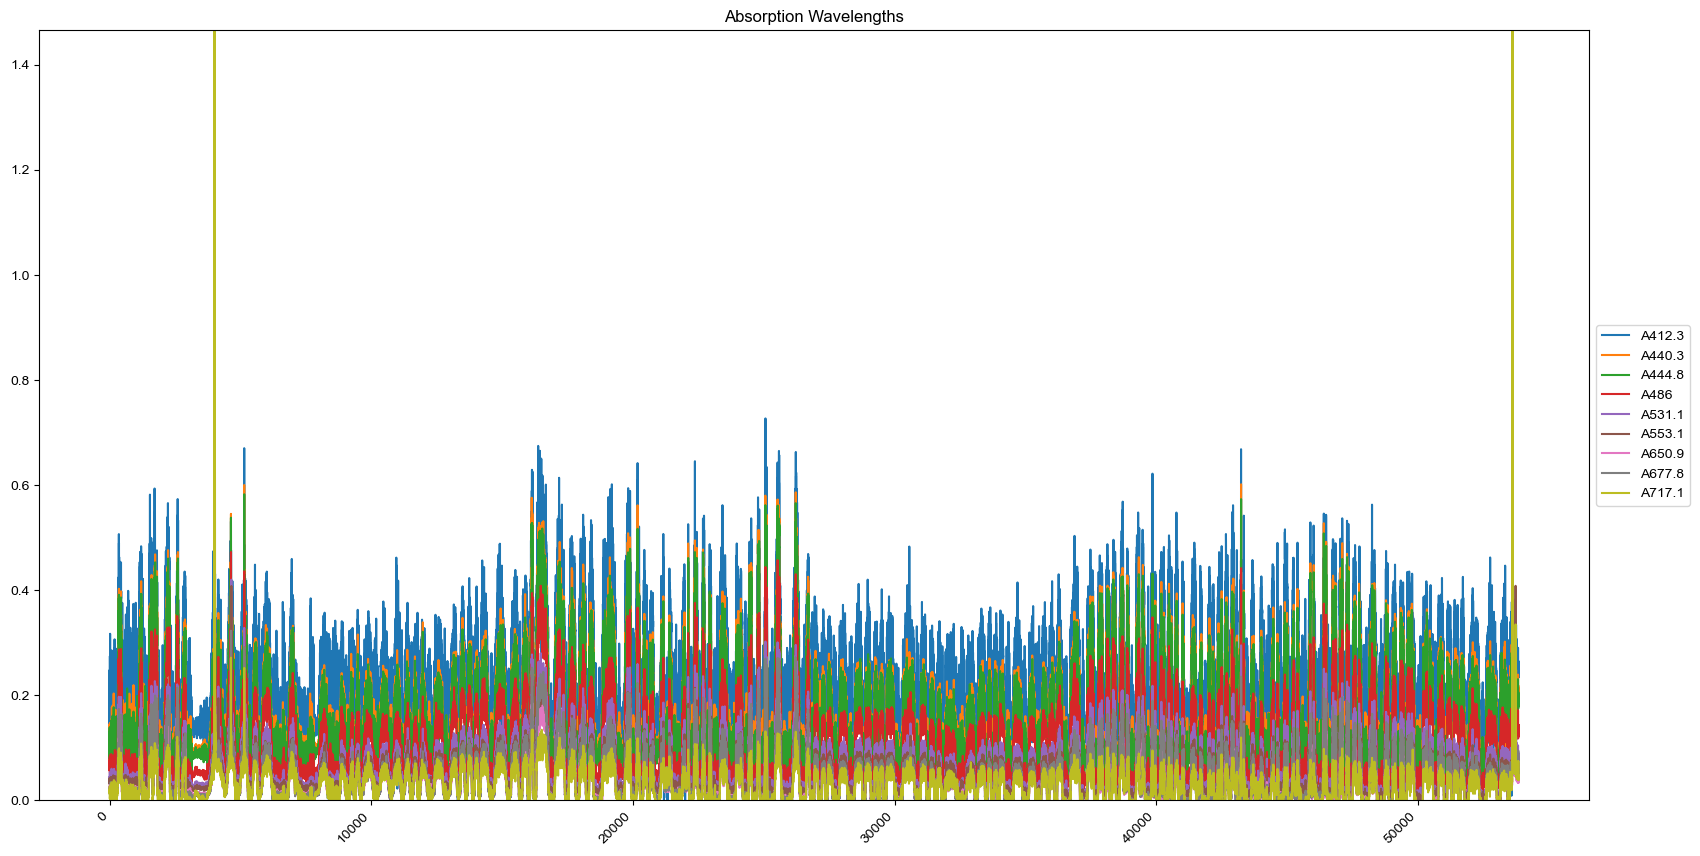

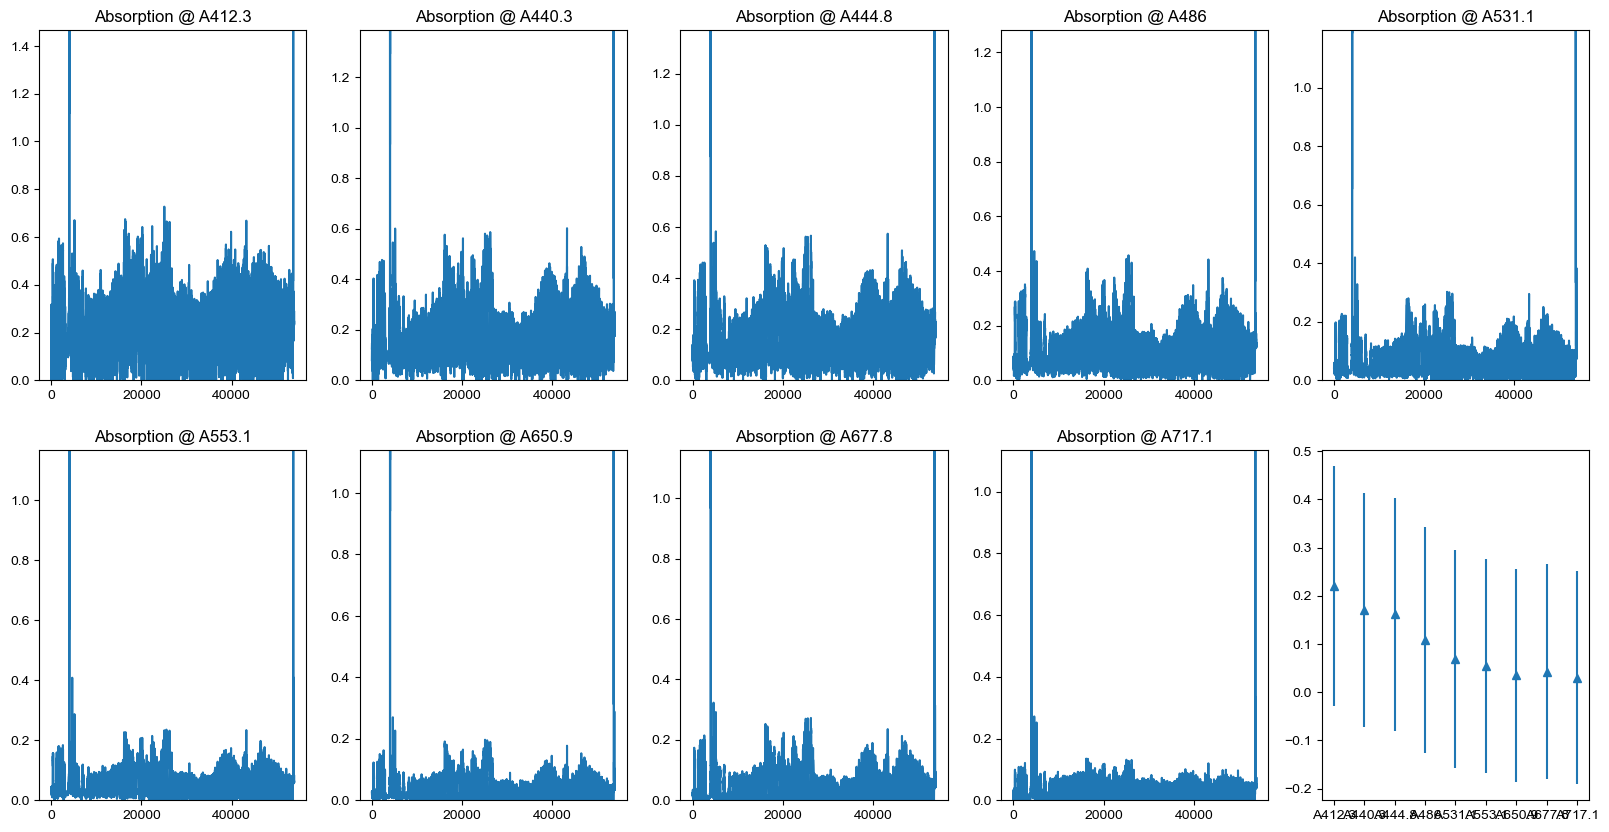

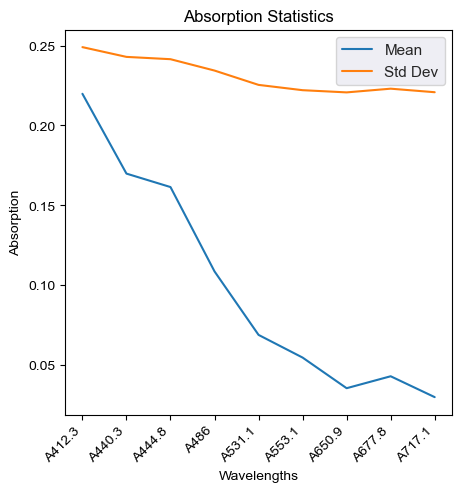

In [22]:
############################################
#ABSORPTION PLOTS
############################################

#Plot along wavelengths showing individual values, all values, and some basic statistics
#Consider this a very basic approach to plotting
#this keeps the plot within the context of this notebook, else the plot will appear in a new window
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
spectra = ['A412.3','A440.3','A444.8','A486',  'A531.1','A553.1','A650.9','A677.8','A717.1']         #Absorption wavelengths in order, WAP doesn't output in order
c = ['C413.9','C442.1','C446.3','C487.6','C532.3','C554.3','C652.7','C674.7','C717.6']         #Beam Attenuation wavelengths in order, WAP doesn't output in order

df_columns=df.columns.values.tolist()
target_col_idx=[]
for val in spectra:
    target_col_idx.append(df_columns.index(val))

  
#constants
PLT_MAX_ROW=2
PLT_MAX_COL=5
PLT_X_SIZE=20
PLT_Y_SIZE=10
PLT_LGD_X_OFFSET=1
PLT_LGD_Y_OFFSET=0.5
PLT_Y_SCALE_STDDEV=5
row_index=0
col_index=0
y_range_limit=20

#statistics
spectra_means=df[df.columns[target_col_idx]].apply(np.mean)
spectra_std  =df[df.columns[target_col_idx]].apply(np.std)
spectra_mean_max=np.max(spectra_means)
spectra_std_max=np.max(spectra_std)
y_range_limit=spectra_mean_max + (spectra_std_max * PLT_Y_SCALE_STDDEV)

#initial fiture creating a 1 x 1 (default) # of plots in one page 20 x 10 in size (makes the plots larger)
fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))
ax=df[df.columns[target_col_idx]].plot(ax=axes)
ax.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET))
labels=ax.get_xticklabels()
plt.setp(labels,rotation=45,horizontalalignment='right')
ax.set_ylim(bottom=0,top=y_range_limit)
ax.set_title(label="Absorption Wavelengths")
ax.set_ylabel="Wavelength"
ax.set_xlabel="Time(s)"
#plt.savefig("./AbsoptionSpectraOverTime.png")
#plt.close()

#initial fiture creating a 2 x 5 # of plots in one page 20 x 10 in size (makes the plots larger)
fig, axes = plt.subplots(PLT_MAX_ROW, PLT_MAX_COL, figsize=(PLT_X_SIZE, PLT_Y_SIZE))
#iterate through the absorption array
for idx in target_col_idx:
    if ( col_index == (PLT_MAX_COL ) ):
        row_index +=1
        col_index = 0
    ax=df[df.columns[idx]].plot(ax=axes[row_index,col_index])
    #legend offset removed, not enough room in the plot screen
    #ax.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET))
    spectra_specific_mean=spectra_means[df.columns[idx]]
    spectra_specific_std=spectra_std[df.columns[idx]]
    y_range_limit=spectra_specific_mean + (spectra_specific_std * PLT_Y_SCALE_STDDEV)
    ax.set_ylim(bottom=0,top=y_range_limit)
    ax.set_title(label="Absorption @ " + df.columns[idx])
    ax.set_ylabel=""
    ax.set_xlabel="Time(s)"
    col_index+=1
    
#output the names of columns to a list; just an example
spectra_names=spectra

#plot the means as the last index in the 2x5 array of plots
plt.set_title='Absorption Means'
plt.setp(labels,rotation=45,horizontalalignment='right')
ax=plt.errorbar(df.columns[target_col_idx],spectra_means, spectra_std, linestyle='None', marker='^' )
#plt.savefig("./AbsoptionSpectraOverTimeSubPlots.png")
#plt.close()

#new figure using seaborn api which "knows" your data based on titles / names
import seaborn as sns
fig, axes = plt.subplots(figsize=(5,5))
sns.set(style="darkgrid")
ax=sns.lineplot(data=spectra_means, label="Mean")
ax=sns.lineplot(data=spectra_std, label="Std Dev")
ax.set_title("Absorption Statistics")
ax.set_ylabel("Absorption")
ax.set_xlabel("Wavelengths")
labels=ax.get_xticklabels()
plt.setp(labels,rotation=45,horizontalalignment='right')
#plt.savefig("./AbsoptionStats.png")
#plt.close()

# Now saving to file system.  Check your local directory for *.png's

In [23]:
############################################
#BEAM ATTENUATION PLOTS
############################################

#Plot along wavelengths showing individual values, all values, and some basic statistics
#Consider this a very basic approach to plotting
#this keeps the plot within the context of this notebook, else the plot will appear in a new window
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
spectra = ['C413.9','C442.1','C446.3','C487.6','C532.3','C554.3','C652.7','C674.7','C717.6']         #Beam Attenuation wavelengths in order, WAP doesn't output in order

df_columns=df.columns.values.tolist()
target_col_idx=[]
for val in spectra:
    target_col_idx.append(df_columns.index(val))

  
#constants
PLT_MAX_ROW=2
PLT_MAX_COL=5
PLT_X_SIZE=20
PLT_Y_SIZE=10
PLT_LGD_X_OFFSET=1
PLT_LGD_Y_OFFSET=0.5
PLT_Y_SCALE_STDDEV=5
row_index=0
col_index=0
y_range_limit=20

#statistics
spectra_means=df[df.columns[target_col_idx]].apply(np.mean)
spectra_std  =df[df.columns[target_col_idx]].apply(np.std)
spectra_mean_max=np.max(spectra_means)
spectra_std_max=np.max(spectra_std)
y_range_limit=spectra_mean_max + (spectra_std_max * PLT_Y_SCALE_STDDEV)

#initial fiture creating a 1 x 1 (default) # of plots in one page 20 x 10 in size (makes the plots larger)
fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))
ax=df[df.columns[target_col_idx]].plot(ax=axes)
ax.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET))
labels=ax.get_xticklabels()
plt.setp(labels,rotation=45,horizontalalignment='right')
ax.set_ylim(bottom=0,top=y_range_limit)
ax.set_title(label="Beam Attenuation Wavelengths")
ax.set_ylabel="Wavelength"
ax.set_xlabel="Time(s)"
plt.savefig("./BeamCSpectraOverTime.png")
plt.close()


#initial fiture creating a 2 x 5 # of plots in one page 20 x 10 in size (makes the plots larger)
fig, axes = plt.subplots(PLT_MAX_ROW, PLT_MAX_COL, figsize=(PLT_X_SIZE, PLT_Y_SIZE))
#iterate through the absorption array
for idx in target_col_idx:
    if ( col_index == (PLT_MAX_COL ) ):
        row_index +=1
        col_index = 0
    ax=df[df.columns[idx]].plot(ax=axes[row_index,col_index])
    #legend offset removed, not enough room in the plot screen
    #ax.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET))
    spectra_specific_mean=spectra_means[df.columns[idx]]
    spectra_specific_std=spectra_std[df.columns[idx]]
    y_range_limit=spectra_specific_mean + (spectra_specific_std * PLT_Y_SCALE_STDDEV)
    ax.set_ylim(bottom=0,top=y_range_limit)
    ax.set_title(label="Beam Attenuation @ " + df.columns[idx])
    ax.set_ylabel=""
    ax.set_xlabel="Time(s)"
    col_index+=1

#output the names of columns to a list; just an example
spectra_names=spectra

#plot the means as the last index in the 2x5 array of plots
plt.set_title='Beam Attenuation'
plt.setp(labels,rotation=45,horizontalalignment='right')
ax=plt.errorbar(df.columns[target_col_idx],spectra_means, spectra_std, linestyle='None', marker='^' )
plt.savefig("./BeamCSpectraOverTimeSubPlots.png")
plt.close()

#new figure using seaborn api which "knows" your data based on titles / names
import seaborn as sns
fig, axes = plt.subplots(figsize=(5,5))
sns.set(style="darkgrid")
ax=sns.lineplot(data=spectra_means, label="Mean")
ax=sns.lineplot(data=spectra_std, label="Std Dev")
ax.set_title("Beam Attenuation Statistics")
ax.set_ylabel("Beam Attenuation")
ax.set_xlabel("Wavelengths")
labels=ax.get_xticklabels()
plt.setp(labels,rotation=45,horizontalalignment='right')
plt.savefig("./BeamCStats.png")
plt.close()

In [24]:
sns.set(style="darkgrid")
marker_size=0.5

fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))
ax=sns.lineplot(data=df['SBE_Pressure(dbar)'], label="Depth")
ax.legend(loc='center left', bbox_to_anchor=(PLT_LGD_X_OFFSET,PLT_LGD_Y_OFFSET))
ax.set_title("Depth Over Time")
ax.set_ylabel("Depth")
ax.set_xlabel("Time")
labels=ax.get_xticklabels()
plt.setp(labels,rotation=45,horizontalalignment='right')
plt.savefig("./DepthOverTime.png")
plt.close()

# More data QA

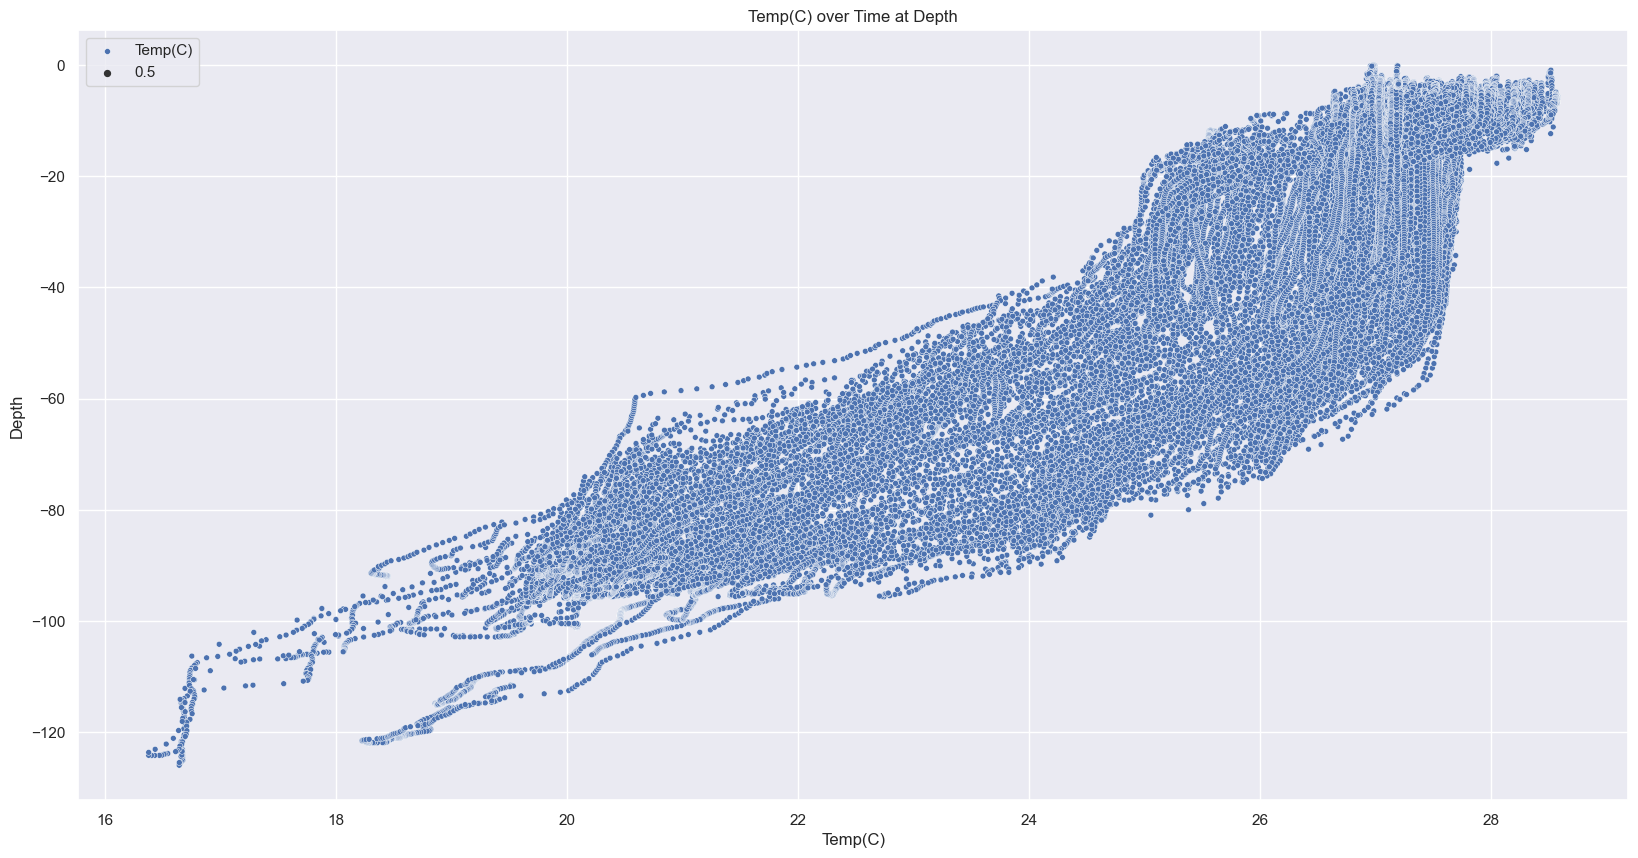

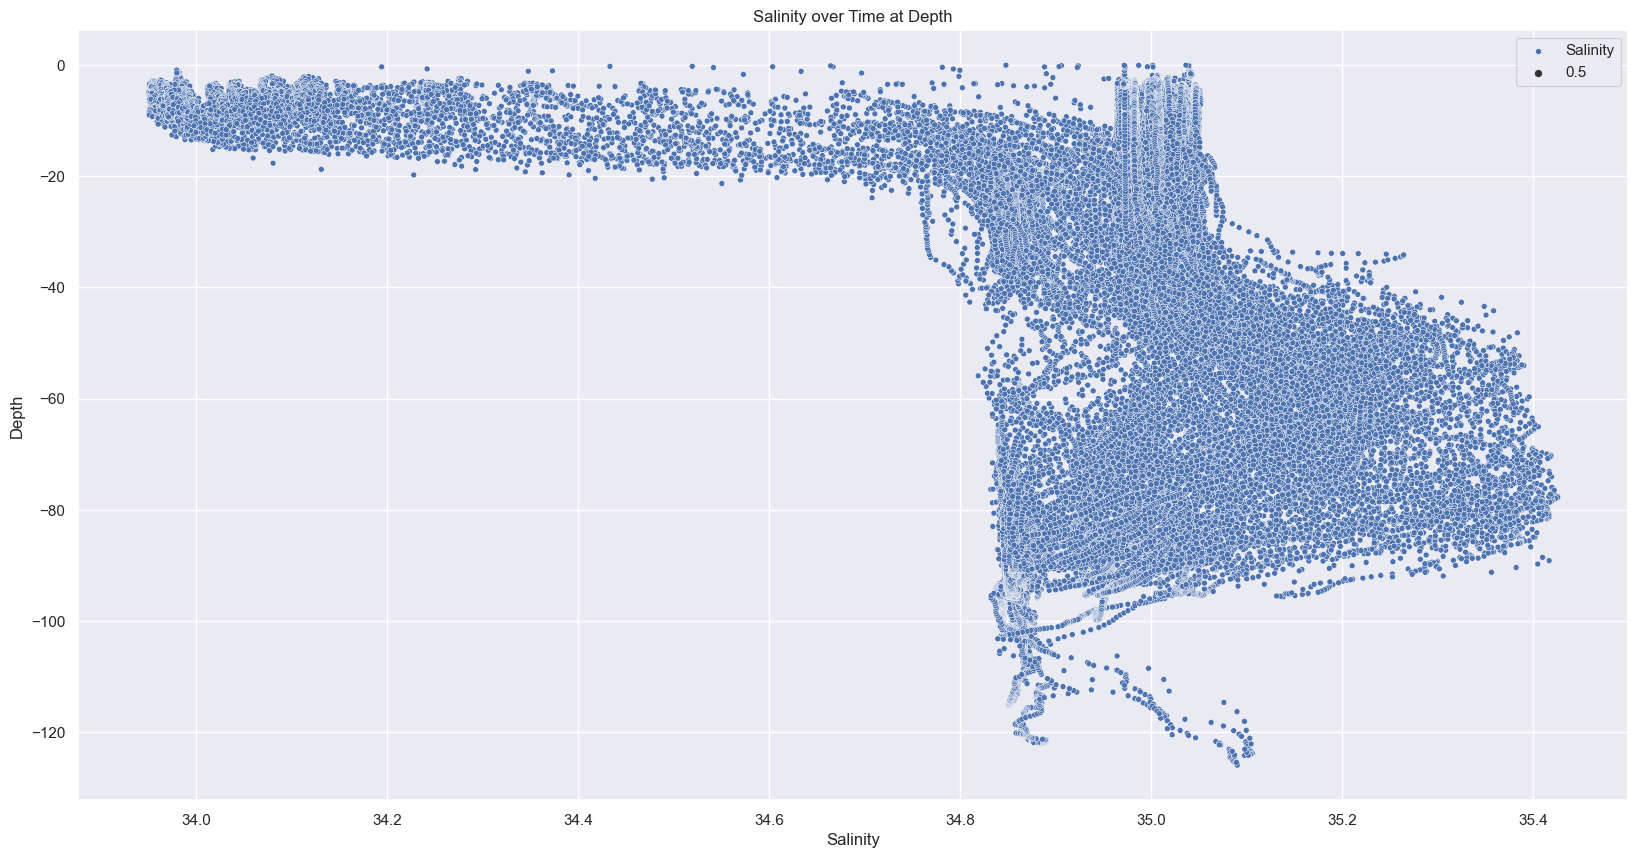

In [25]:
fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))

df['Depth']=df['SBE_Pressure(dbar)'] * (-1.0)
depth_name='Depth'
ax=sns.scatterplot(y=df[depth_name],x=df['SBE_Temperature(C)'], label="Temp(C)",size=marker_size)
ax.set_title("Temp(C) over Time at Depth")
ax.set_ylabel("Depth")
ax.set_xlabel("Temp(C)")
#plt.savefig("./Temperature.png")
#plt.close()

fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))
ax=sns.scatterplot(y=df[depth_name],x=df['SBE_Salinity'], label="Salinity", size=marker_size)
ax.set_title("Salinity over Time at Depth")
ax.set_ylabel("Depth")
ax.set_xlabel("Salinity")
#plt.savefig("./Salinity.png")
#plt.close()

df.drop(columns='Depth', inplace=True)

# Do we know if the data is accurate?  Did the merge actually merge our values?

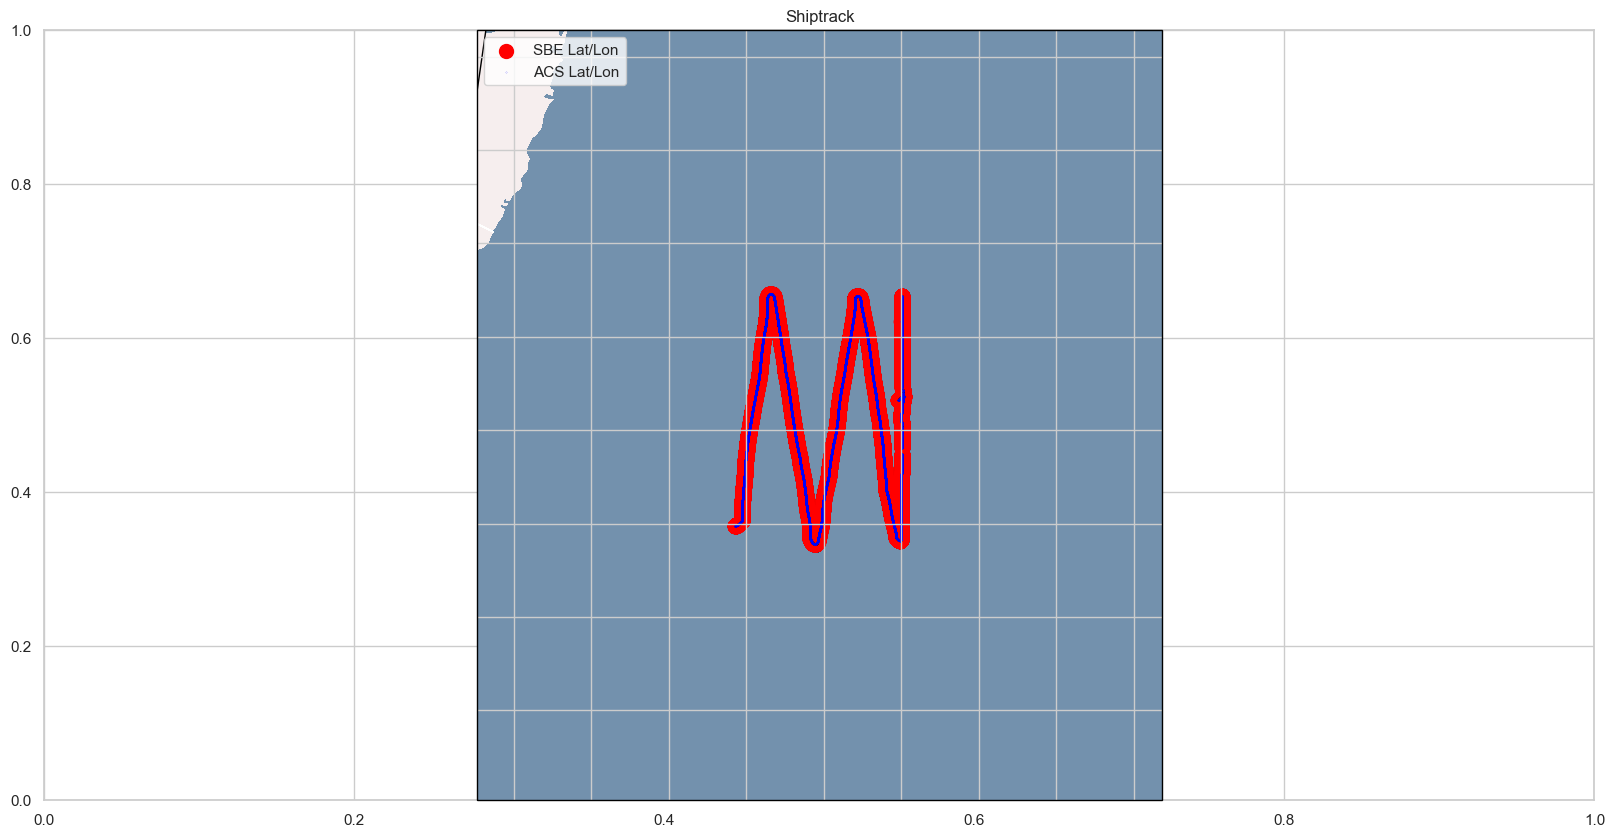

In [26]:
#%matplotlib nbagg
import cartopy.crs as ccrs

sns.set_style("whitegrid")


TARGET_DATAFRAME=df
DIS_MDL_DF=df
DIS_SAT_DF=df

central_longitude=TARGET_DATAFRAME['SBE_Longitude'].median
central_latitude=TARGET_DATAFRAME['SBE_Latitude'].median
west=TARGET_DATAFRAME['SBE_Longitude'].min()   - 0.5
east=TARGET_DATAFRAME['SBE_Longitude'].max()   + 0.5
north=TARGET_DATAFRAME['SBE_Latitude'].max()  + 0.5
south=TARGET_DATAFRAME['SBE_Latitude'].min()  - 0.5

fig, axes = plt.subplots(figsize=(PLT_X_SIZE, PLT_Y_SIZE))
ax = fig.add_subplot(1, 1, 1,projection=ccrs.Miller(central_longitude=central_longitude))
ax.set_extent([west, east, south, north])
ax.coastlines()
#ax.stock_img()
ax.gridlines()
ax.add_wms(wms='http://vmap0.tiles.osgeo.org/wms/vmap0',layers=['basic'])

SAT_COLOR='red'
MDL_COLOR='blue'
SAT_SIZE=100.0
MDL_SIZE=0.01

ax.scatter(DIS_SAT_DF['SBE_Longitude'],DIS_SAT_DF['SBE_Latitude'],c=SAT_COLOR,s=SAT_SIZE, label='SBE Lat/Lon')
ax.scatter(DIS_SAT_DF['ACS_Longitude'],DIS_SAT_DF['ACS_Latitude'],c=MDL_COLOR,s=MDL_SIZE, label='ACS Lat/Lon')
plt.legend(loc='upper left');

ax.set_title("Shiptrack")
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
#plt.savefig("./ShipTrack.png")
#plt.close()
plt.show()

# Save your results

In [27]:
#CREATE AN INITIAL "PROOF" OUTPUT for ANALYSIS
df.to_csv("Initial_ACS_SBE_MergedProof.csv",index=False)

In [28]:
#REARRANGE/TRIM COLUMNS TO SUPPORT WAP OUTPUT
df.drop(columns=['index_y','index_x','Seconds','Date','SBE_Conductivity(S/m)','ACS_Longitude','ACS_Latitude','ACS_Pressure'],inplace=True)

new_df=df.rename(index=str, columns={"Time(ms)": "UTC/GMT_Time","SBE_Longitude": "Longitude","SBE_Latitude": "Latitude","SBE_Salinity": "Salinity", "SBE_Temperature(C)": "Temp(C)"})
df=new_df
show_columns_plain(df.columns)
print("")

new_order=["Latitude","Longitude","UTC/GMT_Time","Temp(C)","Salinity","C400","C404.1","C407.1","C410.5","C413.9","C417.4","C421.5","C426","C430.1","C433.8","C437.9","C442.1","C446.3","C451.1","C455.7","C459.9","C464.1","C468.5","C473.3","C478","C483.1","C487.6","C491.8","C496","C500.1","C504.8","C509.5","C514.4","C519.2","C523.9","C528.2","C532.3","C536.6","C540.9","C545.4","C549.9","C554.3","C558.7","C563.2","C567.6","C571.5","C575.4","C579.3","C582.9","C587.6","C591.7","C596","C600.6","C605","C609.3","C613.9","C618.4","C622.5","C626.5","C630.9","C635","C639.3","C643.6","C647.9","C652.7","C657","C661.4","C665.9","C670.3","C674.7","C678.8","C683.2","C687.1","C690.8","C694.7","C698.9","C702.3","C706.3","C710","C714.2","C717.6","C721.4","C725.6","C729.2","C732.7","C735.9","C739.4","C743.7","A398.4","A402.1","A405.7","A408.9","A412.3","A415.8","A419.8","A424","A428.3","A432.2","A436.1","A440.3","A444.8","A449.5","A454.1","A458.3","A462.4","A466.8","A471.5","A476.4","A481.3","A486","A490.2","A494.4","A498.8","A503.1","A507.8","A512.6","A517.7","A522.5","A526.8","A531.1","A535.3","A539.7","A544.2","A548.7","A553.1","A557.5","A562.2","A566.6","A570.8","A574.6","A578.6","A582","A585.8","A589.6","A594","A598.7","A602.9","A607.6","A611.8","A616.5","A620.9","A625.2","A629.4","A633.7","A637.7","A642.1","A646.4","A650.9","A655.4","A660","A664.7","A669","A673.6","A677.8","A682","A685.9","A690","A693.7","A697.9","A701.7","A705.4","A709.2","A713.4","A717.1","A720.8","A724.6","A728.6","A732.1","A735.6","A738.9","A742.7","SBE_Pressure(dbar)"];
df=df[new_order]
show_columns_plain(df.columns)
print("")
df.head()

df['Salinity']=df['Salinity'].astype(float)
df['Temp(C)']=df['Temp(C)'].astype(float)
new_df=df.dropna()
df=new_df
df.head()

C400 C404.1 C407.1 C410.5 C413.9 C417.4 C421.5 C426 C430.1 C433.8 C437.9 C442.1 C446.3 C451.1 C455.7 C459.9 C464.1 C468.5 C473.3 C478 C483.1 C487.6 C491.8 C496 C500.1 C504.8 C509.5 C514.4 C519.2 C523.9 C528.2 C532.3 C536.6 C540.9 C545.4 C549.9 C554.3 C558.7 C563.2 C567.6 C571.5 C575.4 C579.3 C582.9 C587.6 C591.7 C596 C600.6 C605 C609.3 C613.9 C618.4 C622.5 C626.5 C630.9 C635 C639.3 C643.6 C647.9 C652.7 C657 C661.4 C665.9 C670.3 C674.7 C678.8 C683.2 C687.1 C690.8 C694.7 C698.9 C702.3 C706.3 C710 C714.2 C717.6 C721.4 C725.6 C729.2 C732.7 C735.9 C739.4 C743.7 A398.4 A402.1 A405.7 A408.9 A412.3 A415.8 A419.8 A424 A428.3 A432.2 A436.1 A440.3 A444.8 A449.5 A454.1 A458.3 A462.4 A466.8 A471.5 A476.4 A481.3 A486 A490.2 A494.4 A498.8 A503.1 A507.8 A512.6 A517.7 A522.5 A526.8 A531.1 A535.3 A539.7 A544.2 A548.7 A553.1 A557.5 A562.2 A566.6 A570.8 A574.6 A578.6 A582 A585.8 A589.6 A594 A598.7 A602.9 A607.6 A611.8 A616.5 A620.9 A625.2 A629.4 A633.7 A637.7 A642.1 A646.4 A650.9 A655.4 A660 A664.7 A669 A

C:\CompSci\apps\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\CompSci\apps\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Latitude,Longitude,UTC/GMT_Time,Temp(C),Salinity,C400,C404.1,C407.1,C410.5,C413.9,...,A713.4,A717.1,A720.8,A724.6,A728.6,A732.1,A735.6,A738.9,A742.7,SBE_Pressure(dbar)
0,6.3881,82.5004,0.0000,23.0886,34.8610,0.3842,0.3790,0.3553,0.3232,0.3223,...,0.0181,0.0206,0.0237,0.0262,0.0273,0.0265,0.0275,0.0308,0.0328,56.6524
1,6.3881,82.5004,0.0000,23.0839,34.8597,0.3727,0.3607,0.3435,0.3376,0.3235,...,0.0097,0.0157,0.0194,0.0232,0.0283,0.0309,0.0310,0.0321,0.0303,56.7397
2,6.3880,82.5004,0.0000,23.0667,34.8554,0.2946,0.3047,0.3036,0.3045,0.3032,...,0.0162,0.0160,0.0110,0.0071,0.0076,0.0059,0.0073,0.0073,0.0047,56.8362
3,6.3880,82.5004,0.0000,23.0734,34.8587,0.3509,0.3119,0.3212,0.2961,0.2877,...,0.0195,0.0210,0.0222,0.0236,0.0315,0.0339,0.0283,0.0262,0.0233,56.9339
4,6.3880,82.5004,0.0000,23.0759,34.8589,0.3575,0.3344,0.3338,0.3253,0.3347,...,0.0130,0.0127,0.0109,0.0107,0.0121,0.0140,0.0156,0.0147,0.0199,57.0317


In [29]:
df.to_csv("Final_ACS_SBE_Merged.csv",index=False, sep="\t")